In [56]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import warnings
import glob
warnings.simplefilter(action='ignore', category=FutureWarning)

In [57]:
def read_in_matrices(data_dir, file_suffix=None, zscore=False):
    """
    Reads in a set of individual-subject connectivity matrices stored in data_dir,
    
    Returns a dataframe that is subjects x edges (by vectorizing the upper triangle of each FC matrix).
    
    Assumes:
    - each matrix is stored in a separate file beginning with the subject ID, and
    - matrices are symmetric (squareform); i.e., for a parcellation with 268 nodes, matrices should be 268 x 268
    """
    
    all_fc_data = {}
    for subj in glob.glob(data_dir + "*.txt"):
        # try to find this subject's matrix
        file = subj

        
        # read it in and make sure it's symmetric and has reasonable dimensions
        tmp = np.loadtxt(file,  delimiter=',')
        assert tmp.shape[0]==tmp.shape[1]>1, "Matrix seems to have incorrect dimensions: {}".format(tmp.shape)
        subject = next((s for s in file.split("/")[-1].split('.') if file_suffix in s), None) # returns 'AMBAC070' por exemplo

        # take just the upper triangle and store it in a dictionary
        if ~zscore:
            all_fc_data[subject] = tmp[np.triu_indices_from(tmp, k=1)]
        if zscore:
            all_fc_data[subject] = sp.stats.zscore(tmp[np.triu_indices_from(tmp, k=1)])
    
    
    # Convert dictionary into dataframe
    all_fc_data = pd.DataFrame.from_dict(all_fc_data, orient='index')
    
    return all_fc_data

In [58]:
path = "correlation_matrix/"
all_fc_data = read_in_matrices(path, file_suffix='AMBAC')
all_fc_data = all_fc_data.reset_index().drop_duplicates(subset='index', keep='last').set_index('index').sort_index()


In [59]:
print(all_fc_data.shape)
all_fc_data.head()

(72, 6670)


0         1         2         3         4         5     \
index                                                                  
AMBAC002  0.224453  0.026833 -0.115072 -0.107804 -0.119077  0.098518   
AMBAC005  0.359312  0.246687  0.556772  0.121289 -0.180004  0.382876   
AMBAC006  0.534393  0.111283 -0.173513 -0.025006 -0.092542 -0.051647   
AMBAC007  0.493204  0.056914  0.352139 -0.098430  0.106770 -0.038427   
AMBAC009  0.739659  0.361713  0.579131 -0.021446  0.034835  0.496933   

              6         7         8         9     ...      6660      6661  \
index                                             ...                       
AMBAC002 -0.013074  0.008957  0.054643  0.249948  ...  0.529677  0.000000   
AMBAC005  0.260317  0.033281 -0.264635  0.423935  ...  0.760304  0.000000   
AMBAC006 -0.068786  0.103325 -0.325004  0.455359  ...  0.586871  0.097291   
AMBAC007  0.311217 -0.132460  0.026979  0.228928  ...  0.848102  0.000000   
AMBAC009  0.539170  0.062104  0.146481  0.656779  ...  0.755872  0.000000   

          6662      6663      6664  6665      6666  6667      6668  6669  
index                                                                     
AMBAC002   0.0  0.000000  0.000000   0.0  0.000000   0.0  0.000000   0.0  
AMBAC005   0.0  0.000000  0.000000   0.0  0.000000   0.0  0.000000   0.0  
AMBAC006   0.0  0.042744  0.134844   0.0  0.021347   0.0  0.168665   0.0  
AMBAC007   0.0  0.000000  0.000000   0.0  0.000000   0.0  0.000000   0.0  
AMBAC009   0.0  0.000000  0.000000   0.0  0.000000   0.0  0.000000   0.0  

[5 rows x 6670 columns]

In [86]:
all_fc_data.to_csv('matrix.csv')

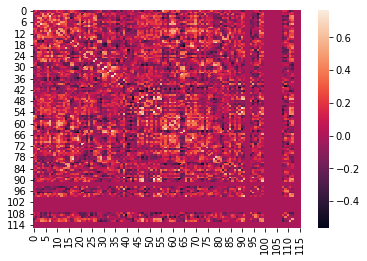

In [60]:
s = 0

sns.heatmap(sp.spatial.distance.squareform(all_fc_data.iloc[s,:]))
plt.show()

In [61]:
def mk_kfold_indices(subj_list, k = 30):
    """
    Splits list of subjects into k folds for cross-validation.
    """
    
    n_subs = len(subj_list)
    n_subs_per_fold = n_subs//k # floor integer for n_subs_per_fold

    indices = [[fold_no]*n_subs_per_fold for fold_no in range(k)] # generate repmat list of indices
    remainder = n_subs % k # figure out how many subs are left over
    remainder_inds = list(range(remainder))
    indices = [item for sublist in indices for item in sublist]    
    [indices.append(ind) for ind in remainder_inds] # add indices for remainder subs

    assert len(indices)==n_subs, "Length of indices list does not equal number of subjects, something went wrong"

    np.random.shuffle(indices) # shuffles in place

    return np.array(indices)

In [62]:
def split_train_test(subj_list, indices, test_fold):
    """
    For a subj list, k-fold indices, and given fold, returns lists of train_subs and test_subs
    """

    train_inds = np.where(indices!=test_fold)
    test_inds = np.where(indices==test_fold)

    train_subs = []
    for sub in subj_list[train_inds]:
        train_subs.append(sub)

    test_subs = []
    for sub in subj_list[test_inds]:
        test_subs.append(sub)

    return (train_subs, test_subs)

In [63]:
def get_train_test_data(all_fc_data, train_subs, test_subs, behav_data, behav):

    """
    Extracts requested FC and behavioral data for a list of train_subs and test_subs
    """

    train_vcts = all_fc_data.loc[train_subs, :]
    test_vcts = all_fc_data.loc[test_subs, :]

    train_behav = behav_data.loc[train_subs, behav]

    return (train_vcts, train_behav, test_vcts)

In [64]:
def select_features(train_vcts, train_behav, r_thresh=0.2, corr_type='spearman', verbose=True):
    
    """
    Runs the CPM feature selection step: 
    - correlates each edge with behavior, and returns a mask of edges that are correlated above some threshold, one for each tail (positive and negative)
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    # Correlate all edges with behav vector
    if corr_type =='pearson':
        cov = np.dot(train_behav.T - train_behav.mean(), train_vcts - train_vcts.mean(axis=0)) / (train_behav.shape[0]-1)
        corr = cov / np.sqrt(np.var(train_behav, ddof=1) * np.var(train_vcts, axis=0, ddof=1))
    elif corr_type =='spearman':
        corr = []
        for edge in train_vcts.columns:
            r_val = sp.stats.spearmanr(train_vcts.loc[:,edge], train_behav)[0]
            corr.append(r_val)

    # Define positive and negative masks
    mask_dict = {}
    mask_dict["pos"] = corr > r_thresh
    mask_dict["neg"] = corr < -r_thresh
    
    if verbose:
        print("Found ({}/{}) edges positively/negatively correlated with behavior in the training set".format(mask_dict["pos"].sum(), mask_dict["neg"].sum())) # for debugging

    return mask_dict

In [65]:
def build_model(train_vcts, mask_dict, train_behav):
    """
    Builds a CPM model:
    - takes a feature mask, sums all edges in the mask for each subject, and uses simple linear regression to relate summed network strength to behavior
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    model_dict = {}

    # Loop through pos and neg tails
    X_glm = np.zeros((train_vcts.shape[0], len(mask_dict.items())))

    t = 0
    for tail, mask in mask_dict.items():
        X = train_vcts.values[:, mask].sum(axis=1)
        X_glm[:, t] = X
        y = train_behav
        (slope, intercept) = np.polyfit(X, y, 1)
        model_dict[tail] = (slope, intercept)
        print(model_dict[tail])
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    model_dict["glm"] = tuple(np.linalg.lstsq(X_glm, y, rcond=None)[0])

    return model_dict

In [66]:
def apply_model(test_vcts, mask_dict, model_dict ):
    """
    Applies a previously trained linear regression model to a test set to generate predictions of behavior.
    """

    behav_pred = {}

    X_glm = np.zeros((test_vcts.shape[0], len(mask_dict.items())))

    # Loop through pos and neg tails
    t = 0
    for tail, mask in mask_dict.items():
        X = test_vcts.loc[:, mask].sum(axis=1)
        X_glm[:, t] = X

        slope, intercept = model_dict[tail]
        behav_pred[tail] = slope*X + intercept
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    behav_pred["glm"] = np.dot(X_glm, model_dict["glm"])

    return behav_pred

In [67]:
def cpm_wrapper(all_fc_data, all_behav_data, behav, k=30, **cpm_kwargs):

    assert all_fc_data.index.equals(all_behav_data.index), "Row (subject) indices of FC vcts and behavior don't match!"

    subj_list = all_fc_data.index # get subj_list from df index
    
    indices = mk_kfold_indices(subj_list, k=k)
    
    # Initialize df for storing observed and predicted behavior
    col_list = []
    for tail in ["pos", "neg", "glm"]:
        col_list.append(behav + " predicted (" + tail + ")")
    col_list.append(behav + " observed")
    behav_obs_pred = pd.DataFrame(index=subj_list, columns = col_list)
    
    # Initialize array for storing feature masks
    n_edges = all_fc_data.shape[1]
    all_masks = {}
    all_masks["pos"] = np.zeros((k, n_edges))
    all_masks["neg"] = np.zeros((k, n_edges))
    
    for fold in range(k):
        print("doing fold {}".format(fold))
        train_subs, test_subs = split_train_test(subj_list, indices, test_fold=fold)
        train_vcts, train_behav, test_vcts = get_train_test_data(all_fc_data, train_subs, test_subs, all_behav_data, behav=behav)
        mask_dict = select_features(train_vcts, train_behav, **cpm_kwargs)
        print(mask_dict["pos"].shape)
        all_masks["pos"][fold,:] = mask_dict["pos"]
        all_masks["neg"][fold,:] = mask_dict["neg"]
        model_dict = build_model(train_vcts, mask_dict, train_behav)
        behav_pred = apply_model(test_vcts, mask_dict, model_dict)
        for tail, predictions in behav_pred.items():
            behav_obs_pred.loc[test_subs, behav + " predicted (" + tail + ")"] = predictions
            
    behav_obs_pred.loc[subj_list, behav + " observed"] = all_behav_data[behav]
    
    return behav_obs_pred, all_masks

In [68]:
all_behav_data = pd.read_csv('resultado_AMBAC.csv', dtype={'Subject': str})
all_behav_data.set_index('fmri_code', inplace=True)
all_behav_data = all_behav_data.reset_index().drop_duplicates(subset='fmri_code', keep='last').set_index('fmri_code').sort_index()

print(all_behav_data.shape)
all_behav_data.head()

(69, 116)


Unnamed: 0 ('Unnamed: 0_level_0', 'Unnamed: 0_level_1', 'Nome')  \
fmri_code                                                                    
AMBAC001            3                     Gregory Moraes Pires do Amaral     
AMBAC002            2                      Estevão de Oliveira Guimarães     
AMBAC003           67                                  Juliane Conceição     
AMBAC005            6                             Livia Freitas Larroque     
AMBAC006            8                            Gabriel Nunes Ferreira      

          ('Unnamed: 2_level_0', 'Unnamed: 2_level_1', 'DX')  \
fmri_code                                                      
AMBAC001                                                   4   
AMBAC002                                                   4   
AMBAC003                                                  EX   
AMBAC005                                                   4   
AMBAC006                                                   4   

          ('QI', 'PSICOLOGIA', 'FEZ QI') ('QI', 'PSICOLOGIA', 'QI Nº')  \
fmri_code                                                                
AMBAC001                               1                            85   
AMBAC002                               1                           103   
AMBAC003                              EX                            EX   
AMBAC005                               1                           103   
AMBAC006                               1                           126   

          ('QI', 'PSICOLOGIA', 'SIGNIFICADO')  \
fmri_code                                       
AMBAC001                           médio inf.   
AMBAC002                                médio   
AMBAC003                                   EX   
AMBAC005                                Média   
AMBAC006                             Superior   

          ('MEMÓRIA DE TRABALHO', 'BLOCOS DE CORSI', 'Ordem direta bruto')  \
fmri_code                                                                    
AMBAC001                                                  NC                 
AMBAC002                                                  NC                 
AMBAC003                                                  EX                 
AMBAC005                                                  NC                 
AMBAC006                                                  NC                 

          ('MEMÓRIA DE TRABALHO', 'BLOCOS DE CORSI', 'Span direto')  \
fmri_code                                                             
AMBAC001                                                  NC          
AMBAC002                                                  NC          
AMBAC003                                                  EX          
AMBAC005                                                  NC          
AMBAC006                                                  NC          

          ('MEMÓRIA DE TRABALHO', 'BLOCOS DE CORSI', 'Ordem inversa bruto')  \
fmri_code                                                                     
AMBAC001                                                  NC                  
AMBAC002                                                  NC                  
AMBAC003                                                  EX                  
AMBAC005                                                  NC                  
AMBAC006                                                  NC                  

          ('MEMÓRIA DE TRABALHO', 'BLOCOS DE CORSI', 'span inverso')  ...  \
fmri_code                                                             ...   
AMBAC001                                                  NC          ...   
AMBAC002                                                  NC          ...   
AMBAC003                                                  EX          ...   
AMBAC005                                                  NC          ...   
AMBAC006                                                  NC          ...   

          fMR

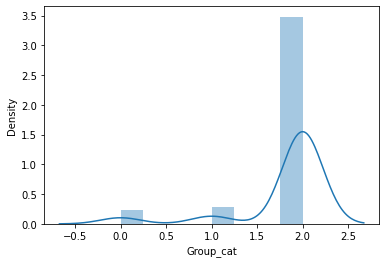

In [69]:
behav = 'Group_cat'

sns.distplot(all_behav_data[behav])
plt.show()

In [70]:
# all_fc_data.loc[all_behav_data]

all_fc_data = all_fc_data.loc[all_fc_data.index.intersection(all_behav_data.index)]
all_behav_data = all_behav_data.loc[all_behav_data.index.intersection(all_fc_data.index)]

In [71]:
cpm_kwargs = {'r_thresh': 0.2, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit

behav_obs_pred, all_masks = cpm_wrapper(all_fc_data, all_behav_data, behav=behav, **cpm_kwargs)

doing fold 0
Found (333/792) edges positively/negatively correlated with behavior in the training set
(6670,)
(0.02303664706130272, 1.8319339134482837)
(-0.006272657583784343, 2.3929938691381283)
doing fold 1
Found (325/729) edges positively/negatively correlated with behavior in the training set
(6670,)
(0.023810646640720804, 1.8072166366584677)
(-0.00690117165387, 2.3462360617295484)
doing fold 2
Found (322/774) edges positively/negatively correlated with behavior in the training set
(6670,)
(0.023900260976434863, 1.821537511718833)
(-0.006579577825908185, 2.360482177825572)
doing fold 3
Found (322/700) edges positively/negatively correlated with behavior in the training set
(6670,)
(0.024589379885787688, 1.7840035878202258)
(-0.00751043032836282, 2.3551890371364985)
doing fold 4
Found (335/774) edges positively/negatively correlated with behavior in the training set
(6670,)
(0.02335837574513051, 1.810257678405176)
(-0.006599518596810282, 2.3674138897144217)
doing fold 5
Found (328/8

In [72]:
behav_obs_pred

Group_cat predicted (pos) Group_cat predicted (neg)  \
AMBAC002                   1.83678                   2.20702   
AMBAC005                   1.91519                   2.09177   
AMBAC006                   1.83746                   2.10912   
AMBAC007                   2.13712                   1.47642   
AMBAC009                   2.22933                   1.53131   
AMBAC010                   1.83271                    1.9702   
AMBAC011                   1.97169                   2.00939   
AMBAC012                   1.66282                   2.26535   
AMBAC015                   1.84118                   2.01339   
AMBAC016                   2.09197                   1.66502   
AMBAC017                   1.95892                   2.32433   
AMBAC019                   1.76883                   1.93784   
AMBAC021                   2.03792                   1.87213   
AMBAC022                   2.03152                   1.62733   
AMBAC023                   1.89653                   2.16835   
AMBAC024                   1.97767                   2.04592   
AMBAC025                   1.76539                   2.09269   
AMBAC026                   1.90932                   1.52718   
AMBAC027                   1.88742                   2.14969   
AMBAC029                   1.87583                   2.03953   
AMBAC030                   1.76591                   1.52567   
AMBAC031                   1.75485                   2.07565   
AMBAC033                  0.781947                  0.960887   
AMBAC034                   1.72557                   2.35563   
AMBAC035                   1.76728                    2.1523   
AMBAC036                    1.9107                    2.0759   
AMBAC038                   1.82595                   2.11267   
AMBAC043                   1.83706                   1.53982   
AMBAC054                   1.79251                   1.87394   
AMBAC055                   1.25729                   1.32008   
AMBAC056                   1.76024                     1.679   
AMBAC057                   1.36718                   1.43503   
AMBAC059                   1.70886                    1.6304   
AMBAC060                  0.931106                   1.77941   
AMBAC062                   1.46006                   1.38239   
AMBAC063                   1.49974                     1.603   
AMBAC064                   1.44266                    1.2949   
AMBAC066                    1.9235                    1.9245   
AMBAC067                   1.81079                   1.81811   
AMBAC068                   2.07067                   2.03014   
AMBAC069                   2.67052                   1.05874   
AMBAC070                   1.70998                   1.61412   
AMBAC071                    2.0285                   1.71441   
AMBAC072                    1.3905                   1.53119   
AMBAC073                   1.79247                   1.42823   
AMBAC075                   2.06637                   1.54601   
AMBAC076                   1.74585                   1.86361   
AMBAC077                   2.05302                   2.08907   
AMBAC079                   2.27692                   1.32619   
AMBAC082                   2.16416                   1.75282   
AMBAC083                   1.92759                   1.79473   
AMBAC087                   1.64507                   1.70764   
AMBAC091                   2.03502                   1.80124   
AMBAC098                   1.73362                   1.60972   
AMBAC099                    1.6098                   1.89612   
AMBAC101                   1.49224                    1.7361   

         Group_cat predicted (glm) Group_cat observed  
AMBAC002                   2.03835                  2  
AMBAC005                   2.03352                  2  
AMBAC006                    1.9934                  2  
AMBAC007                   1.90016                  2  
AMBAC009                   2.00054                  1  
AMBAC010                

In [73]:
import numpy

size_X = 116 #tamanho do atlas?
X = np.zeros((size_X,size_X))
X[np.triu_indices(X.shape[0], k = 1)] = all_masks['pos'][29]
final_positive_matrix = X + X.T
numpy.savetxt('positive_matrix.txt', final_positive_matrix, delimiter = ',')  

In [74]:
X = np.zeros((size_X,size_X))
X[np.triu_indices(X.shape[0], k = 1)] = all_masks['neg'][29]
final_negative_matrix = X + X.T
numpy.savetxt('negative_matrix.txt', final_positive_matrix, delimiter = ',')  

In [75]:
def plot_predictions(behav_obs_pred, tail="glm"):
    x = behav_obs_pred.filter(regex=("obs")).astype(float)
    y = behav_obs_pred.filter(regex=(tail)).astype(float)
    g = sns.regplot(x=x.T.squeeze(), y=y.T.squeeze(), color='gray')
    ax_min = min(min(g.get_xlim()), min(g.get_ylim()))
    ax_max = max(max(g.get_xlim()), max(g.get_ylim()))
    g.set_xlim(ax_min, ax_max)
    g.set_ylim(ax_min, ax_max)
    g.set_aspect('equal', adjustable='box')
     
    r = sp.stats.pearsonr(x.iloc[:,-1],y.iloc[:,-1])[0]
    g.annotate('r = {0:.2f}'.format(r), xy = (0.7, 0.1), xycoords = 'axes fraction')
    
    return g

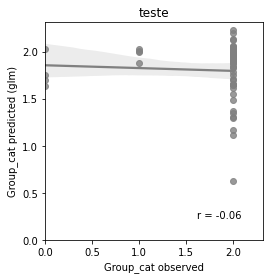

In [76]:
g = plot_predictions(behav_obs_pred)
g.set_title('teste')
plt.show()

In [77]:
from nilearn.plotting import plot_connectome

def plot_consistent_edges(all_masks, tail, thresh = 1., color='gray'):
    
    edge_frac = (all_masks[tail].sum(axis=0))/(all_masks[tail].shape[0])
    print("For the {} tail, {} edges were selected in at least {}% of folds".format(tail, (edge_frac>=thresh).sum(), thresh*100))
    edge_frac_square = sp.spatial.distance.squareform(edge_frac)

    node_mask = np.amax(edge_frac_square, axis=0) >= thresh # find nodes that have at least one edge that passes the threshold
    node_size = edge_frac_square.sum(axis=0)*node_mask*5 # size nodes based on how many suprathreshold edges they have

    plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                    node_color = color,
                    node_coords=coordinates, node_size=node_size,
                    display_mode= 'lzry',
                    edge_kwargs={"linewidth": 1, 'color': color})

In [78]:
from nilearn import datasets, plotting

atlas = datasets.fetch_atlas_aal()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# # Loading atlas data stored in 'labels'
# networks = atlas['networks']
labels = atlas['labels']

coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)


----
### Now we define a function that will take in all_masks, calculate the consistency of each edge (i.e., how frequently it is selected across all k-fold iterations), and visualize only those edges that meet some consistency threshold (expressed as a percentage of times selected):



For the pos tail, 64 edges were selected in at least 98.0% of folds


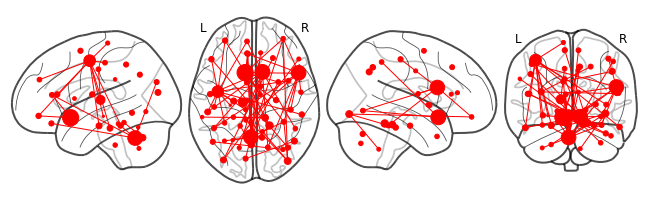

In [79]:
plot_consistent_edges(all_masks, "pos", thresh = 0.98, color = 'red')


For the neg tail, 125 edges were selected in at least 98.0% of folds


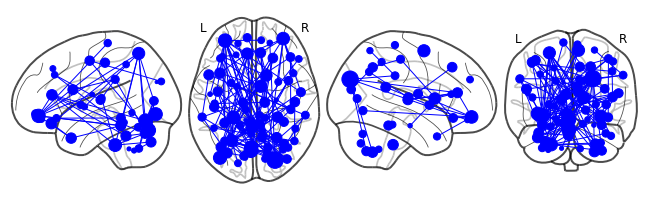

In [80]:
plot_consistent_edges(all_masks, "neg", thresh = 0.98, color = 'blue')


Eu tava bastante focada no CPM porque o marcon me sugeriu que seria uma abordagem interessante pra avaliar brain-behavior.

Mas agora que eu to pesquisando mais a fundo tô em duvida se é a melhor abordagem pra verificar relação de "causalidade". 

Na banca, o Rodrigo criticou considerar o CPM uma abordagem preditiva, mas que o meu trabalho era uma analise DESCRITIVA.

Será que não seria interessante eu propor avaliar outros métodos pra verificar relação causa e efeito entre dados socioeconomicos e a fmri?

Uma coisa que eu concordo que ele tenha mencionado é que eu não devo focar em "descobrir a relação causal" mas talvez no método como daria para observar, ainda que talvez nesse dataset a gente não consiga observar que existe efetivamente uma relação entre dados comportamentais e socioeconomicos. 

## Minha questão de pesquisa: What are the main neurobiological and behavioral relationships between dyslexic children and poor readers from multimodal data?

### We propose an analysis using machine learning as a tool to observe the relationships and differences in neurological traits among children who just do not read well (poor readers), or who are diagnosed with dyslexia


Dúvida: eu preciso criar algo novo no mestrado? Tipo usar uma metodologia diferente para fazer brain-behavioral analise? 

Dúvida: como eu consigo visualizar as áreas do cérebro como fazem nos artigos de CPM?

Dúvida: queria ajuda pra interpretar os resultados do CPM. 

* Qual é o meu entregável? Seria um modelo capaz de mostrar diferenças e/ou semelhanças entre crianças dislexicas e más leitoras? Seria uma avaliação de N modelos e ver qual performa melhor nesse contexto? Seria um modelo mais otimizado que outros da literatura (como uma adaptação, sei lá)? Seria uma abordagem de causal learning no contexto de fmri e dislexia (Artigo: Six problems for causal inference from fMRI)? Adaptar o CPM para multivariaveis?

No PEP eu falei sobre "multivariavel" e "multimodal", multivariavel seria eu ter 2 ou mais variaveis dependentes,certo? A classe social pode ser uma variavel dependente? Tipo dislexia e classe social? Porque se pensar assim, eu poderia dizer que as conexões cerebrais afetam a classe social, mas na verdade eu queria inferir o contrário ....

### tentar modificar a forma resume as variaveis
### 

"Many different algorithms can be used to build predictive models from brain data, including support vector machines/regression (SVM/R), partial least squares regression (PLSR), neural networks, penalized regression (e.g., ridge, least absolute shrinkage and selection operator [LASSO], and elastic net), and random forests."

### Inferencia causal ou Causal learning

In [81]:
# variavel alvo: dislexico - mau leitor  - controle / dislexico - não dislexico

# variaveis comportamentais:

# variaveis socioeconomicas:

# fmri - série temporal: 